# Part 1


## part a and b and c

Imports

In [1]:
# box 1 for in-class
# explain each import and from statement...what does it do and why do you need it
# Imports all the necessary libraries and functions that we will use later
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

Import Data and resize to 500x500

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- 1. Define transforms ---
# Resize, convert to tensor, normalize
transform = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1),
    transforms.Resize((500, 500)),       # resize all images to 128x128
    transforms.ToTensor()#,               # convert to tensor
    #transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])  # normalize to [-1,1]
])

# --- 2. Load datasets ---
train_dataset = datasets.ImageFolder(root='Data/Project3Data/train', transform=transform)
val_dataset   = datasets.ImageFolder(root='Data/Project3Data/val', transform=transform)
test_dataset  = datasets.ImageFolder(root='Data/Project3Data/test', transform=transform)

# --- 3. Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

# --- 4. Check class mapping ---
print("Class to index mapping:", train_dataset.class_to_idx)
# Output example: {'0': 0, '1': 1}


Class to index mapping: {'0': 0, '1': 1}


Confirm that labels are functioning correctly

In [3]:
images, labels = next(iter(train_loader))
print(images.shape)  # [batch_size, channels, height, width]
print(labels)        # tensor of 0s and 1s


torch.Size([32, 3, 500, 500])
tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1])


Looking at example images

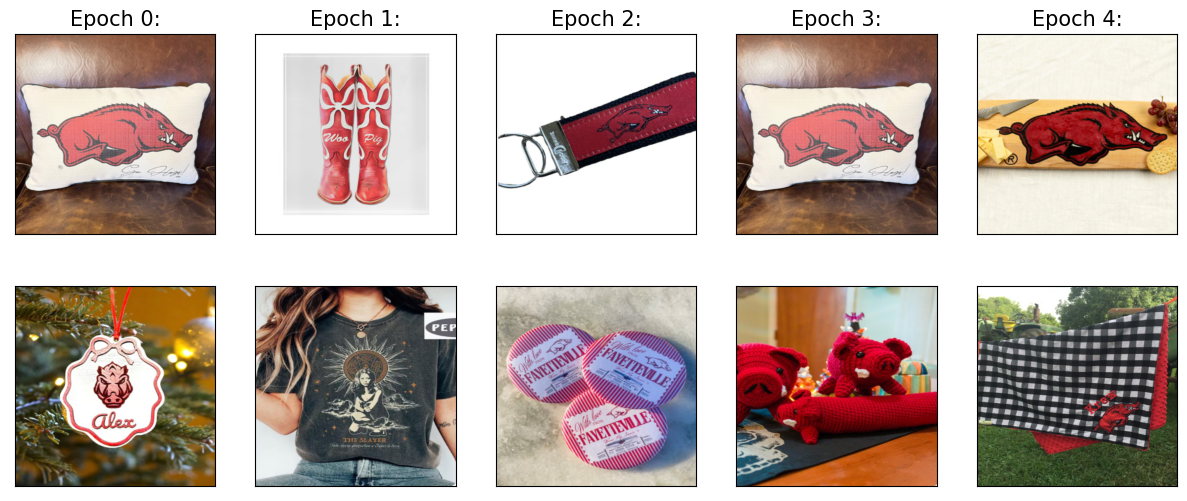

In [4]:
# box 6   
# Plots images during each epoch
fig = plt.figure(figsize=(15, 6))

num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(train_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))


#plt.savefig('figures/14_16.png', dpi=300)
plt.show()

## part c

Initialize base model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------
# Box 10 + 12: Convolutional backbone
# ------------------------

# Creates the CNN backbone as a Sequential model
model = nn.Sequential()

# --- Conv Block 1 ---
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   # 500 -> 250
model.add_module('dropout1', nn.Dropout(p=0.25))

# --- Conv Block 2 ---
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))   # 250 -> 125
model.add_module('dropout2', nn.Dropout(p=0.25))

# --- Conv Block 3 ---
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))   # 125 -> 62

# --- Conv Block 4 ---
model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

# --- Adaptive Pooling to reduce flattened size ---
# This ensures output size is always [batch, 256, 8, 8] regardless of input
model.add_module('adaptive_pool', nn.AdaptiveAvgPool2d((8, 8)))

# --- Flatten before fully connected ---
model.add_module('flatten', nn.Flatten())  # 256*8*8 = 16384 features

# ------------------------
# Box 13: Fully connected + output
# ------------------------

# Fully connected layer
model.add_module('fc', nn.Linear(256*8*8, 512))
model.add_module('relu_fc', nn.ReLU())
model.add_module('dropout_fc', nn.Dropout(p=0.5))

# Output layer for binary classification
model.add_module('output', nn.Linear(512, 1))
model.add_module('sigmoid', nn.Sigmoid())

# ------------------------
# Test with dummy input
# ------------------------
# x = torch.ones((4, 3, 500, 500))  # batch of 4 RGB images, 500x500
# print("Output shape:", model(x).shape)  # should be [4,1]


Uses gpu if available

In [6]:
# box 16
# Uses gpu is possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assings gpu to model
model = model.to(device)

In [7]:
# box 17
# Creates loss function
loss_fn = nn.BCELoss()

# Initalizes optimizer funciton
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# box 18
# Creates training funciton
def train(model, num_epochs, train_dl, valid_dl):

    # Allows for tracking of metadata
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    # Iterates for each epoch
    for epoch in range(num_epochs):

        # Seets to train mode
        model.train()

        # Analyzes training performance for each batch 
        for x_batch, y_batch in train_dl:
            # Moves data to gpu
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # gets predicitons
            pred = model(x_batch)[:, 0]

            # gets loss values
            loss = loss_fn(pred, y_batch.float())

            # performs backwards propogation 
            loss.backward()

            # Takes steps
            optimizer.step()

            # Finds correct gradients for model
            optimizer.zero_grad()

            # Keeps track of epoch metadata
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        # Gets overall loss and accruacy measures
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # Gets evaluation metrics
        model.eval()

        # Adds values to history arrays
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    # Returns arrays displaying progress of the model across 
    # training, can be used to measure where to end epoch, 
    # for example
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


## part b

Training the base model

In [9]:
# Sets seed for reproducability
torch.manual_seed(1)

# original example had 30 but it took ~1 hour to run 15 epochs
num_epochs = 100

# Trains and gives history to hist
hist = train(model, num_epochs, train_loader, val_loader)

Epoch 1 accuracy: 0.4211 val_accuracy: 0.5000
Epoch 2 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 3 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 4 accuracy: 0.6579 val_accuracy: 0.5000
Epoch 5 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 6 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 7 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 8 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 9 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 10 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 11 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 12 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 13 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 14 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 15 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 16 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 17 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 18 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 19 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 20 accuracy: 0.7368 val_accuracy: 0.5000
Epoch 21 accuracy: 0.7368 val_accuracy: 0.5000
Epoch 22 accuracy: 0.7

Looking at statistics

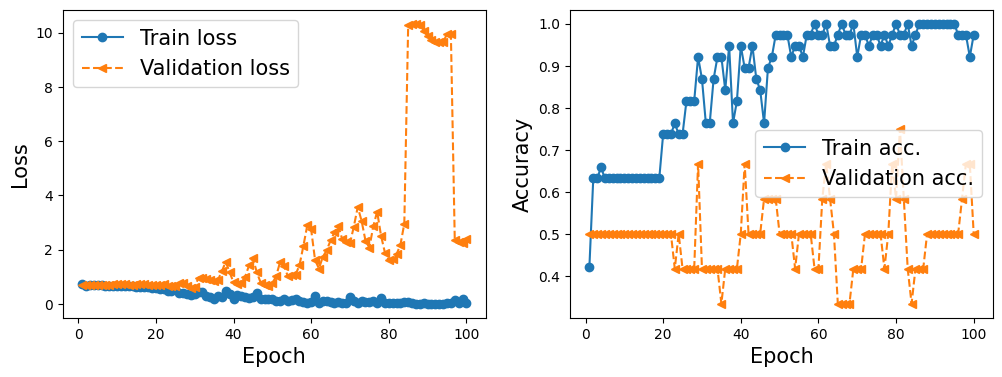

In [10]:
# box 20 describe overall...include if you are happy with 
# Plots results. Overall 50% isn't great
# as it's just a coinflip
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_17.png', dpi=300)
plt.show()

In [11]:
# box 21
accuracy_test = 0

# Switches to evaluation mode
model.eval()

# Disables gradient computation for getting accuracy
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()

accuracy_test /= len(test_loader.dataset)

print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.6000


Looking at test cases

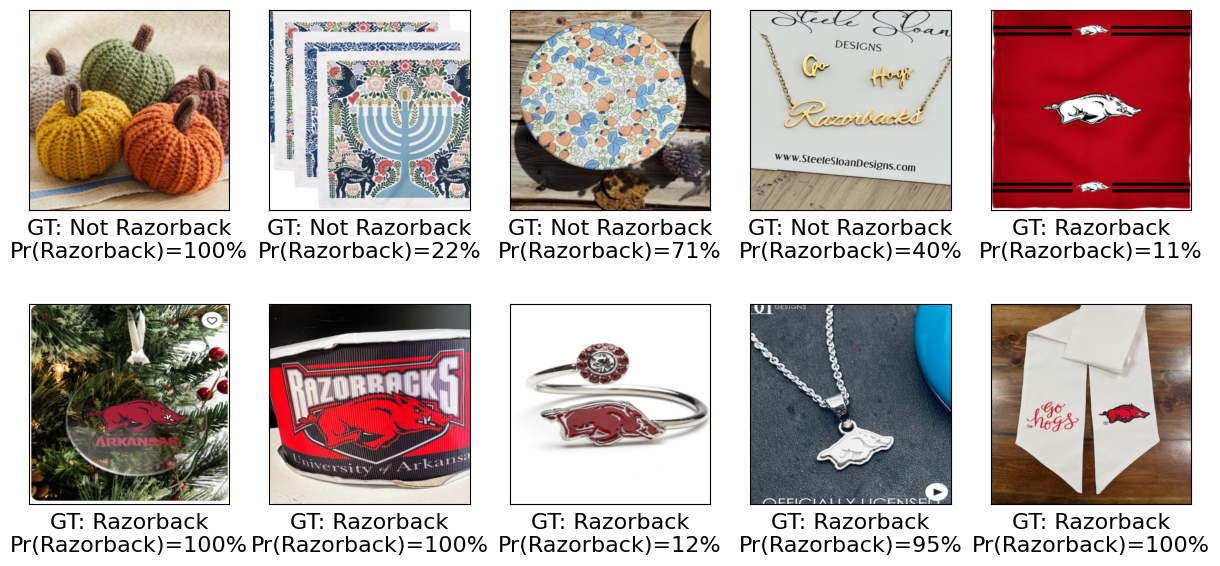

In [12]:
pred = model(x_batch)[:, 0].detach().cpu() * 100  # predictions on CPU

fig = plt.figure(figsize=(15, 7))

for j in range(len(x_batch)):  # loop over actual batch size
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])

    # Move image to CPU and permute
    img_to_show = x_batch[j].cpu().permute(1, 2, 0)
    img_to_show = torch.clamp(img_to_show, 0, 1)
    ax.imshow(img_to_show)

    # Label
    label = 'Razorback' if int(y_batch[j].item()) == 1 else 'Not Razorback'

    ax.text(
        0.5, -0.15,
        f'GT: {label}\nPr(Razorback)={pred[j]:.0f}%',
        size=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes
    )

plt.show()


## part d

Hyper parameter tuning

In [13]:
### Intialize 4 new models for hyperparameter tuning with different layer types
model0 = nn.Sequential( # Initial Base Model
    # --- Conv Block 1 ---
    nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2), nn.Dropout(0.25),  # 500 -> 250

    # --- Conv Block 2 ---
    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2), nn.Dropout(0.25),  # 250 -> 125

    # --- Conv Block 3 ---
    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),                     # 125 -> 62

    # --- Conv Block 4 ---
    nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),

    # --- Adaptive Pooling ---
    nn.AdaptiveAvgPool2d((8, 8)),

    # --- Flatten ---
    nn.Flatten(),  # 256*8*8 = 16384 features

    # --- Fully connected ---
    nn.Linear(256*8*8, 512), nn.ReLU(),
    nn.Dropout(0.5),

    # --- Output layer ---
    nn.Linear(512, 1), nn.Sigmoid()
)


model1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2), nn.Dropout(0.2),   # 500 -> 250

    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2), nn.Dropout(0.3),   # 250 -> 125

    nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),                     # 125 -> 62

    nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),

    nn.AdaptiveAvgPool2d((8,8)),
    nn.Flatten(),

    nn.Linear(256*8*8, 256), nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(256,1), nn.Sigmoid()
)

model2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(2), nn.Dropout(0.25),  # 500 -> 250

    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2), nn.Dropout(0.25),  # 250 -> 125

    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),                     # 125 -> 62

    nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),

    nn.AdaptiveAvgPool2d((8,8)),
    nn.Flatten(),

    nn.Linear(256*8*8, 512), nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512,1), nn.Sigmoid()
)

model3 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2), nn.Dropout(0.1),  # 500 -> 250

    nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2), nn.Dropout(0.2),  # 250 -> 125

    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),                     # 125 -> 62

    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),

    nn.AdaptiveAvgPool2d((8,8)),
    nn.Flatten(),

    nn.Linear(128*8*8, 1024), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512), nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512,1), nn.Sigmoid()
)

model4 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2), nn.Dropout(0.3),  # 500 -> 250

    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2), nn.Dropout(0.4),  # 250 -> 125

    nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),                     # 125 -> 62

    nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(),

    nn.AdaptiveAvgPool2d((8,8)),
    nn.Flatten(),

    nn.Linear(512*8*8, 1024), nn.ReLU(),
    nn.Dropout(0.6),

    nn.Linear(1024,1), nn.Sigmoid()
)




In [ ]:
### Iterate across models
model_list = [0, 1, 2, 3, 4]
learning_rates = [1,.01,.0001]
epochs = [1,10,50]

hyperparameter_history = [] # Format: model, eta, epoch_num, loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid
# Sets seed for reproducability
torch.manual_seed(1)

for i in model_list:
    for j in learning_rates:
        for k in epochs:
            if i == 0: # We have to reinitialize the model everytime so we dont train the same one
                model = nn.Sequential( # Initial Base Model
                    # --- Conv Block 1 ---
                    nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2), nn.Dropout(0.25),  # 500 -> 250

                    # --- Conv Block 2 ---
                    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2), nn.Dropout(0.25),  # 250 -> 125

                    # --- Conv Block 3 ---
                    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2),                     # 125 -> 62

                    # --- Conv Block 4 ---
                    nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),

                    # --- Adaptive Pooling ---
                    nn.AdaptiveAvgPool2d((8, 8)),

                    # --- Flatten ---
                    nn.Flatten(),  # 256*8*8 = 16384 features

                    # --- Fully connected ---
                    nn.Linear(256*8*8, 512), nn.ReLU(),
                    nn.Dropout(0.5),

                    # --- Output layer ---
                    nn.Linear(512, 1), nn.Sigmoid()
                )
            elif i == 1:
                model = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2), nn.Dropout(0.2),   # 500 -> 250

                    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2), nn.Dropout(0.3),   # 250 -> 125

                    nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2),                     # 125 -> 62

                    nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),

                    nn.AdaptiveAvgPool2d((8,8)),
                    nn.Flatten(),

                    nn.Linear(256*8*8, 256), nn.ReLU(),
                    nn.Dropout(0.4),

                    nn.Linear(256,1), nn.Sigmoid()
                )
            elif i == 2:
                model = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=5, padding=2), nn.ReLU(),
                    nn.MaxPool2d(2), nn.Dropout(0.25),  # 500 -> 250

                    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2), nn.Dropout(0.25),  # 250 -> 125

                    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
                    nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2),                     # 125 -> 62

                    nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),

                    nn.AdaptiveAvgPool2d((8,8)),
                    nn.Flatten(),

                    nn.Linear(256*8*8, 512), nn.ReLU(),
                    nn.Dropout(0.5),

                    nn.Linear(512,1), nn.Sigmoid()
                )
            elif i == 3:
                model = nn.Sequential(
                    nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2), nn.Dropout(0.1),  # 500 -> 250

                    nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2), nn.Dropout(0.2),  # 250 -> 125

                    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2),                     # 125 -> 62

                    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),

                    nn.AdaptiveAvgPool2d((8,8)),
                    nn.Flatten(),

                    nn.Linear(128*8*8, 1024), nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(1024, 512), nn.ReLU(),
                    nn.Dropout(0.5),

                    nn.Linear(512,1), nn.Sigmoid()
                )
            elif i == 4:
                model = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2), nn.Dropout(0.3),  # 500 -> 250

                    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2), nn.Dropout(0.4),  # 250 -> 125

                    nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(2),                     # 125 -> 62

                    nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(),

                    nn.AdaptiveAvgPool2d((8,8)),
                    nn.Flatten(),

                    nn.Linear(512*8*8, 1024), nn.ReLU(),
                    nn.Dropout(0.6),

                    nn.Linear(1024,1), nn.Sigmoid()
                )

            torch.manual_seed(1)

            # Uses gpu is possible
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            # Assings gpu to model
            model = model.to(device)

            # Creates loss function
            loss_fn = nn.BCELoss()

            # Initalizes optimizer funciton
            optimizer = torch.optim.Adam(model.parameters(), lr=j)

            # Trains and gives history to hist
            loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train(model, k, train_loader, val_loader)
            hyperparameter_history.append((model,j,k,loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid))
            # train returns: loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid
            print(f'Model Type {i}, ETA {j} Epoch {k} accuracy: {accuracy_hist_train[k-1]:.4f} val_accuracy: {accuracy_hist_valid[k-1]:.4f}')
# Best model: Model Type 1, ETA 0.0001 Epoch 50 accuracy: 0.7895 val_accuracy: 0.5833


Model Type 0, ETA 1 Epoch 1 accuracy: 0.6316 val_accuracy: 0.5000
Model Type 0, ETA 1 Epoch 10 accuracy: 0.6316 val_accuracy: 0.5000
Model Type 0, ETA 1 Epoch 50 accuracy: 0.6316 val_accuracy: 0.5000
Model Type 0, ETA 0.01 Epoch 1 accuracy: 0.4211 val_accuracy: 0.5000
Model Type 0, ETA 0.01 Epoch 10 accuracy: 0.6316 val_accuracy: 0.5000
Model Type 0, ETA 0.01 Epoch 50 accuracy: 0.6316 val_accuracy: 0.5000
Model Type 0, ETA 0.0001 Epoch 1 accuracy: 0.4211 val_accuracy: 0.5000
Model Type 0, ETA 0.0001 Epoch 10 accuracy: 0.6316 val_accuracy: 0.5000
Model Type 0, ETA 0.0001 Epoch 50 accuracy: 0.6842 val_accuracy: 0.5000
Model Type 1, ETA 1 Epoch 1 accuracy: 0.4211 val_accuracy: 0.5000
Model Type 1, ETA 1 Epoch 10 accuracy: 0.6316 val_accuracy: 0.5000
Model Type 1, ETA 1 Epoch 50 accuracy: 0.6316 val_accuracy: 0.5000
Model Type 1, ETA 0.01 Epoch 1 accuracy: 0.4211 val_accuracy: 0.5000
Model Type 1, ETA 0.01 Epoch 10 accuracy: 0.6316 val_accuracy: 0.5000
Model Type 1, ETA 0.01 Epoch 50 accur

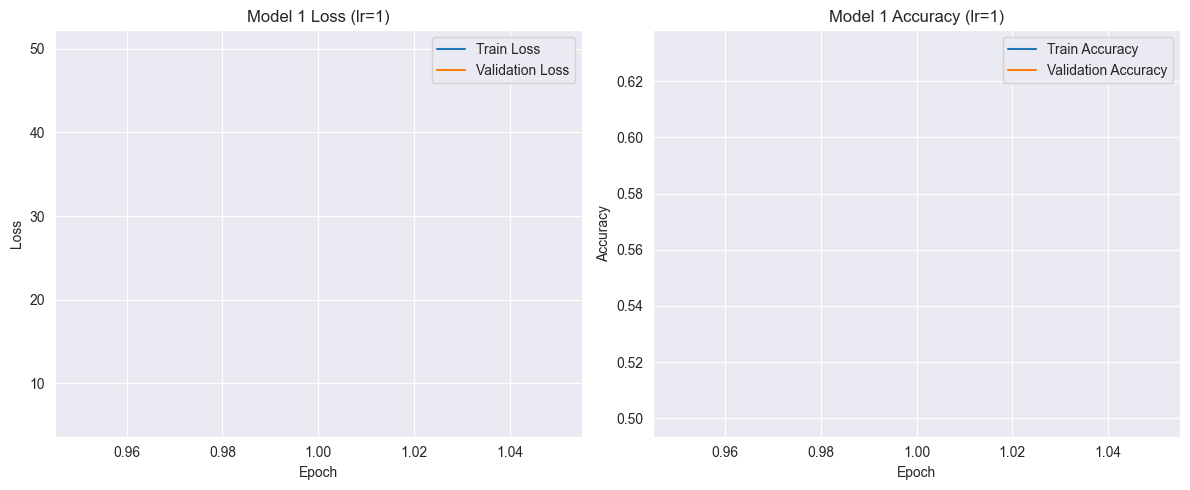

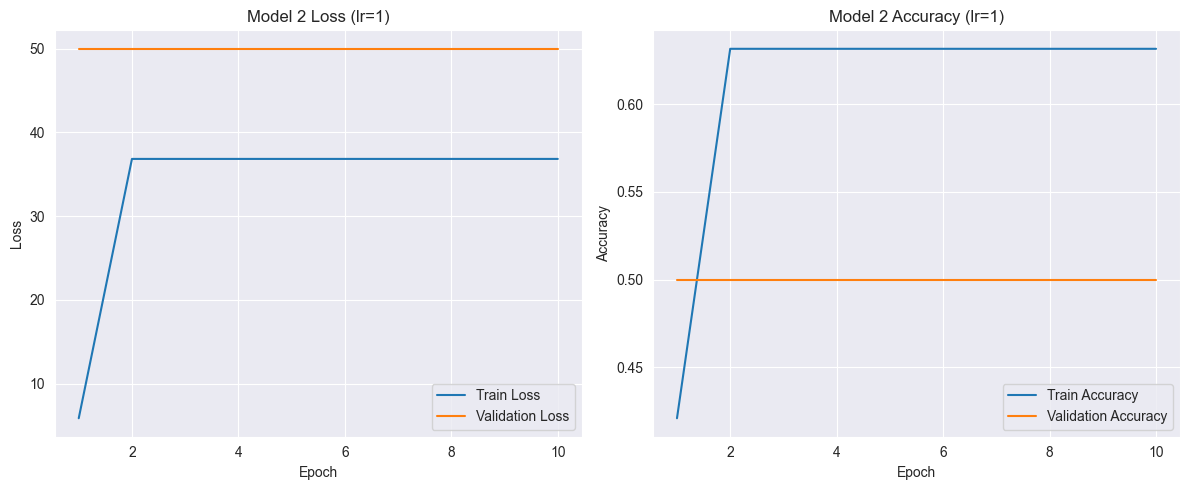

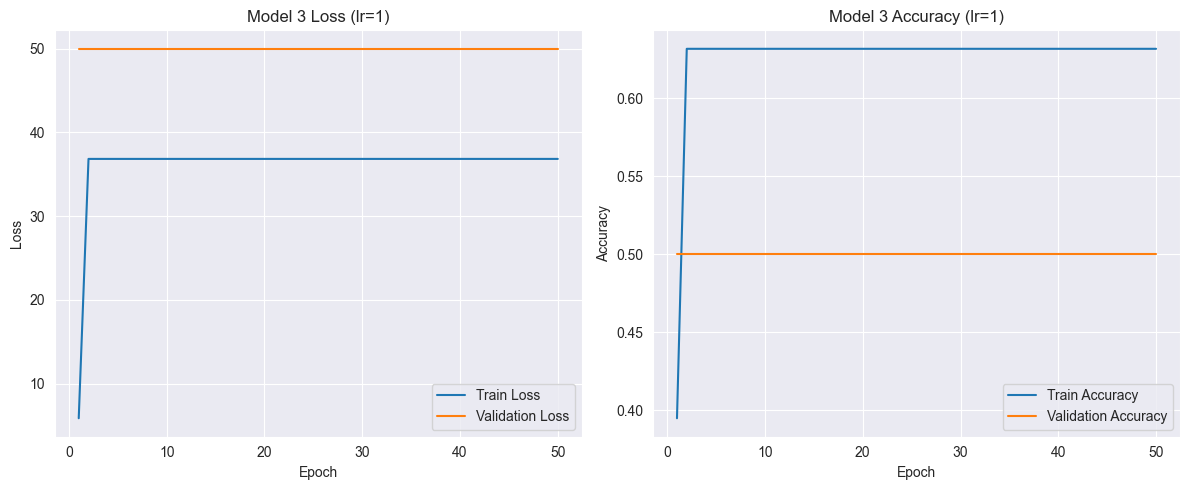

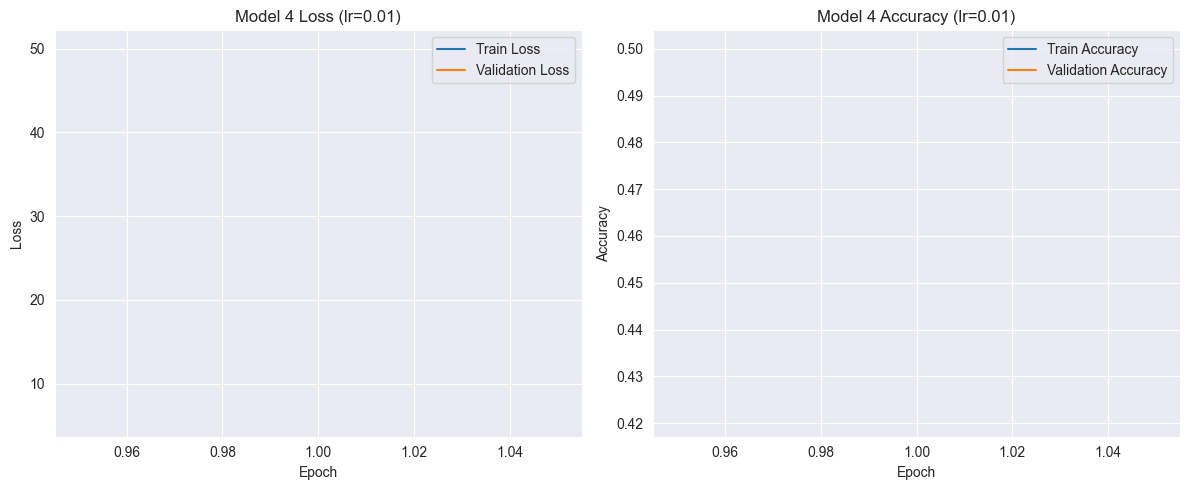

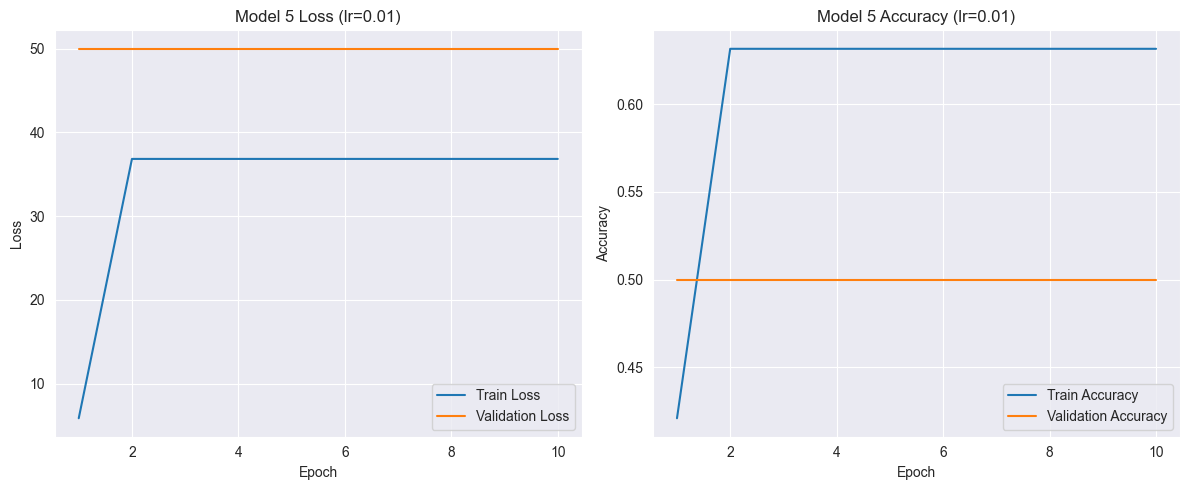

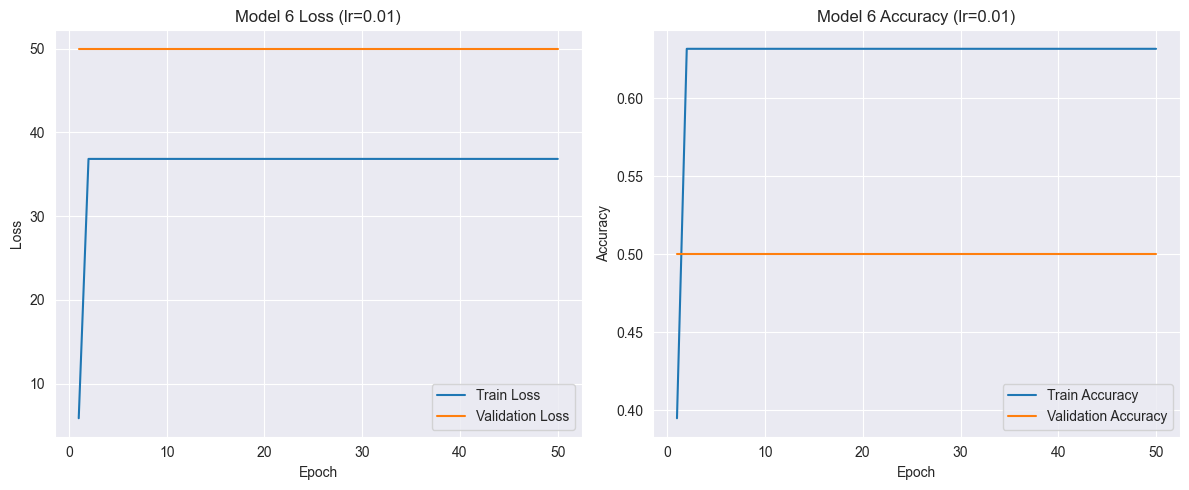

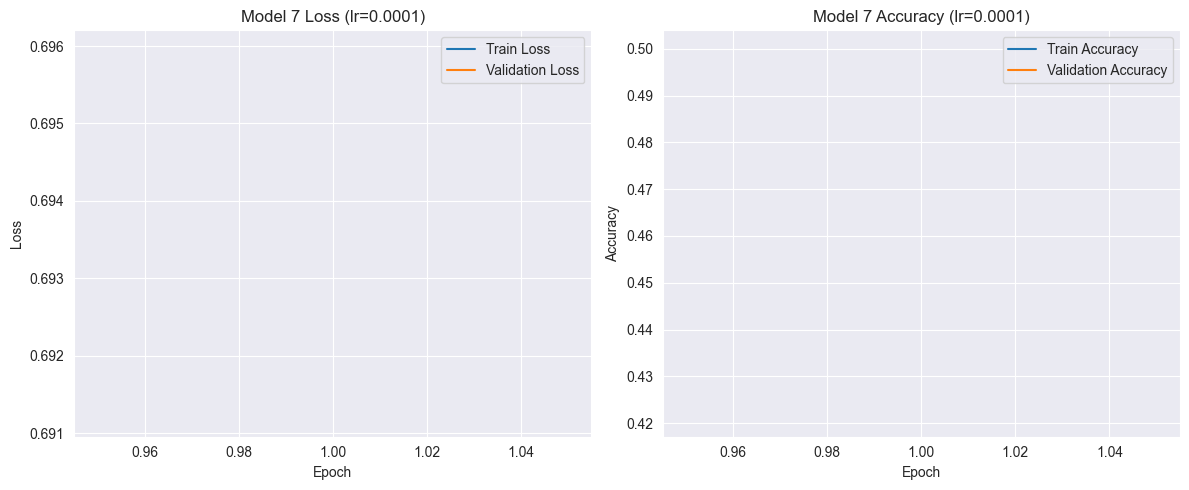

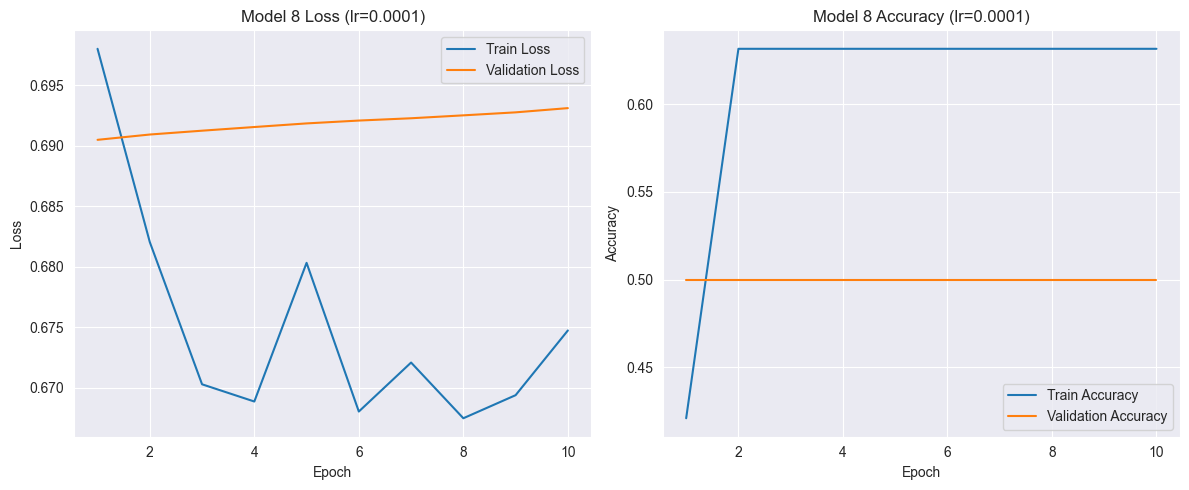

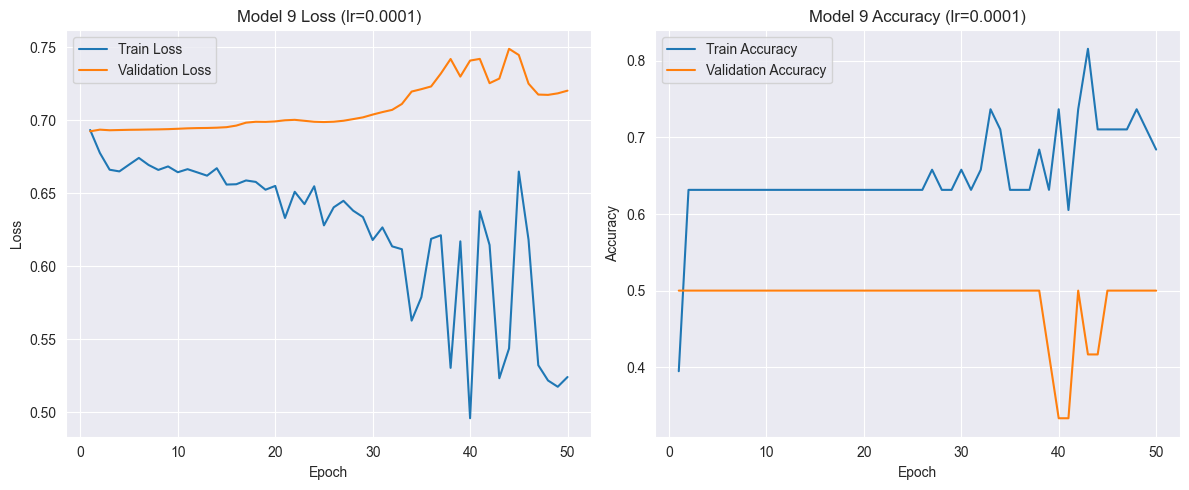

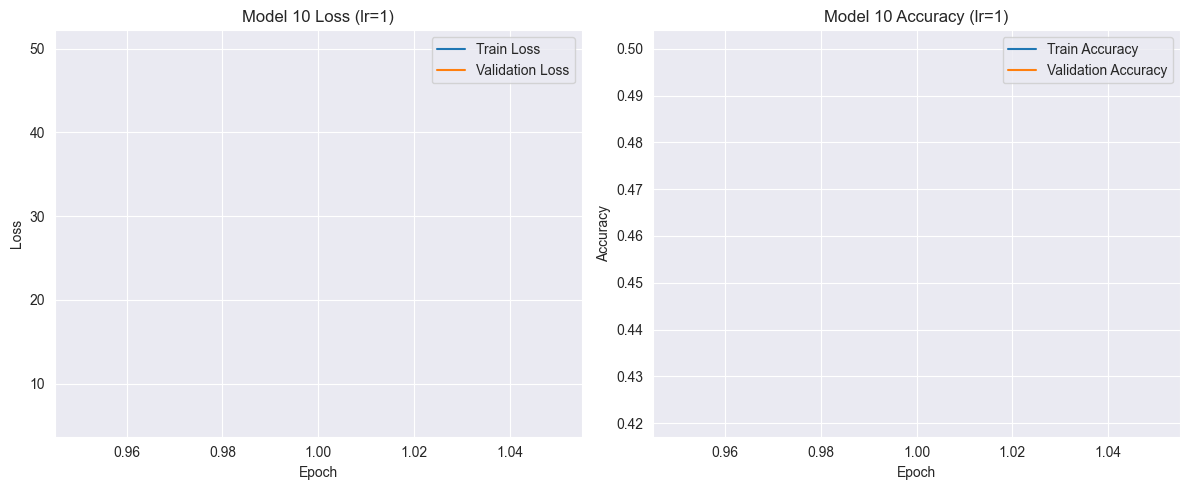

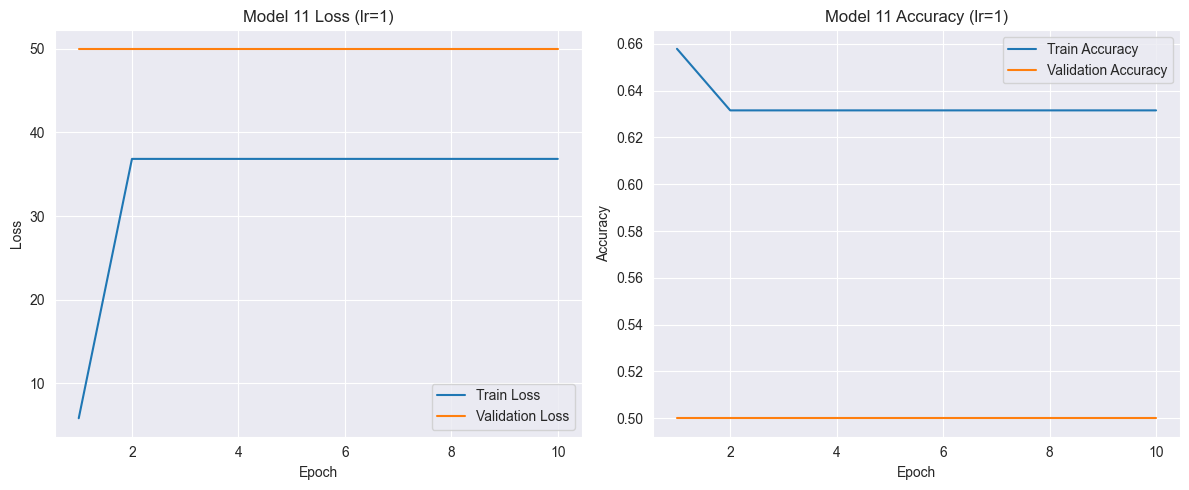

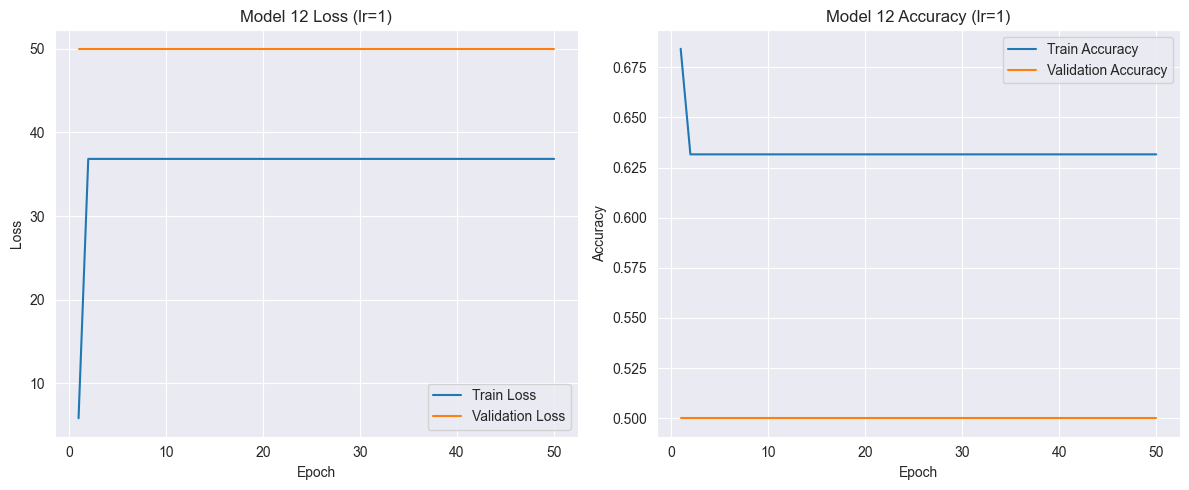

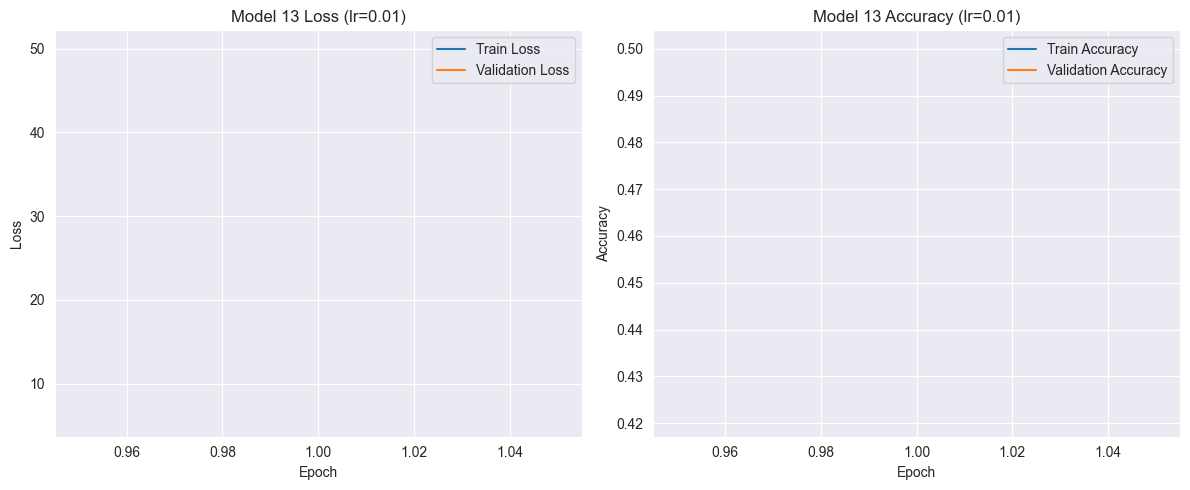

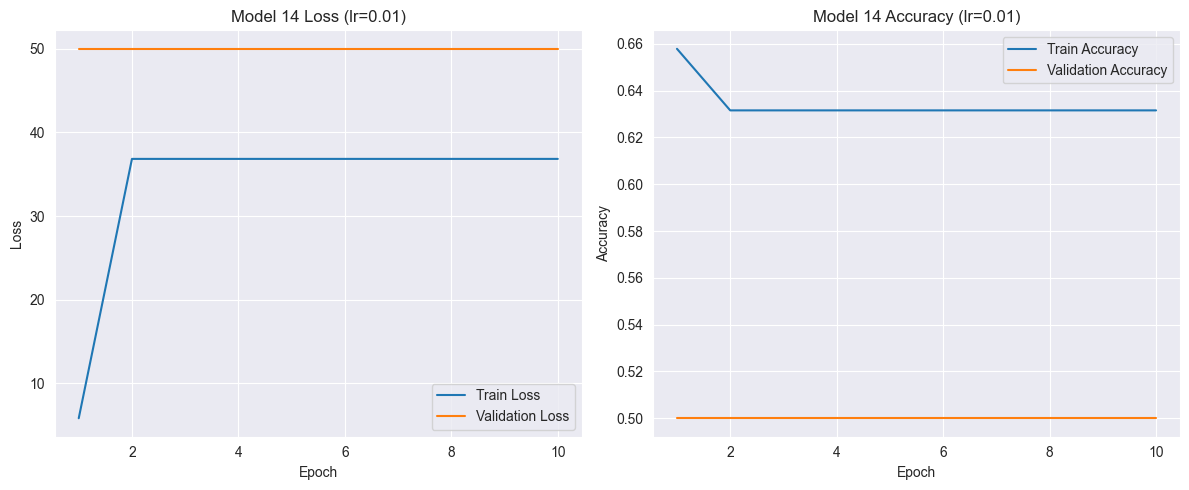

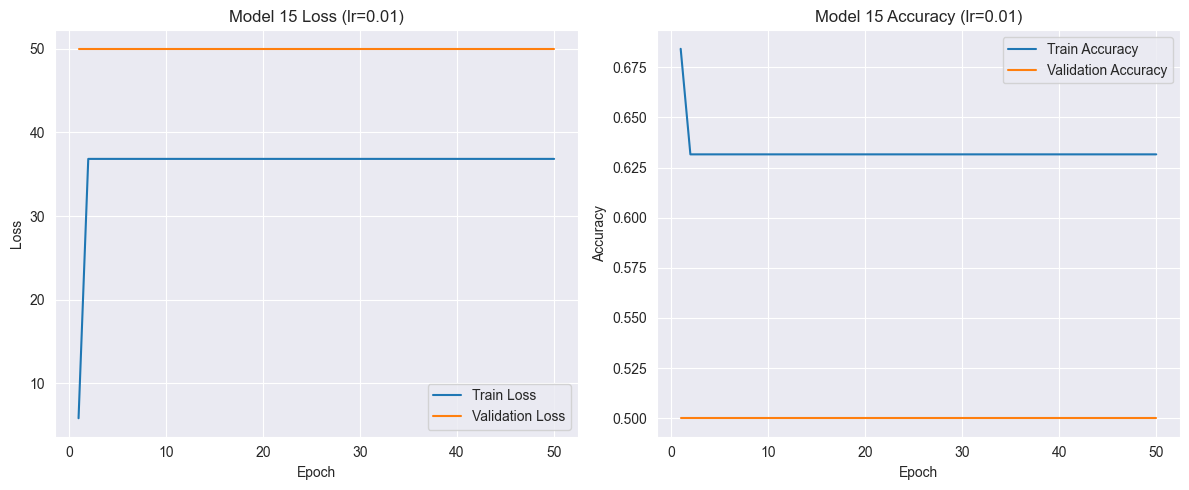

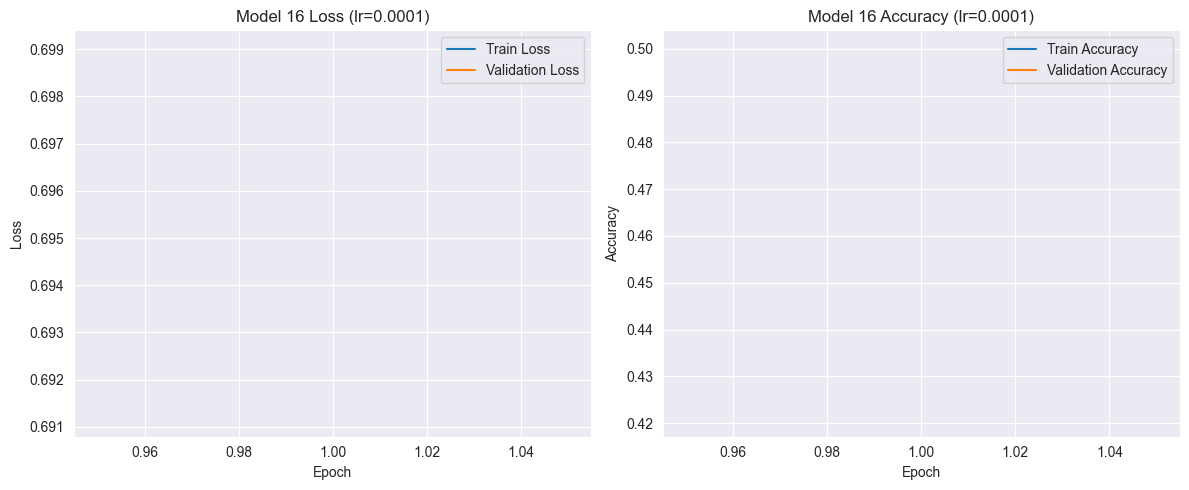

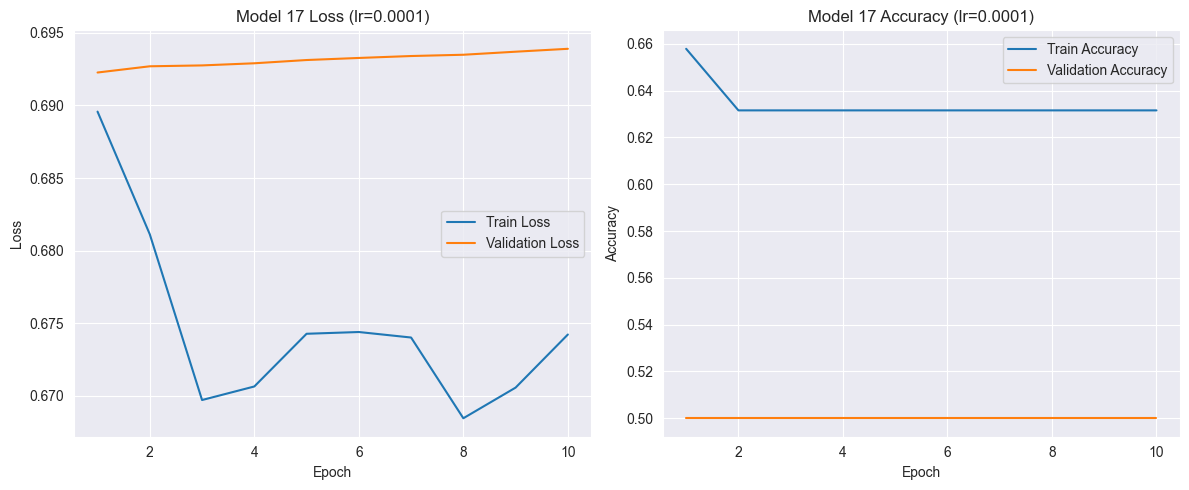

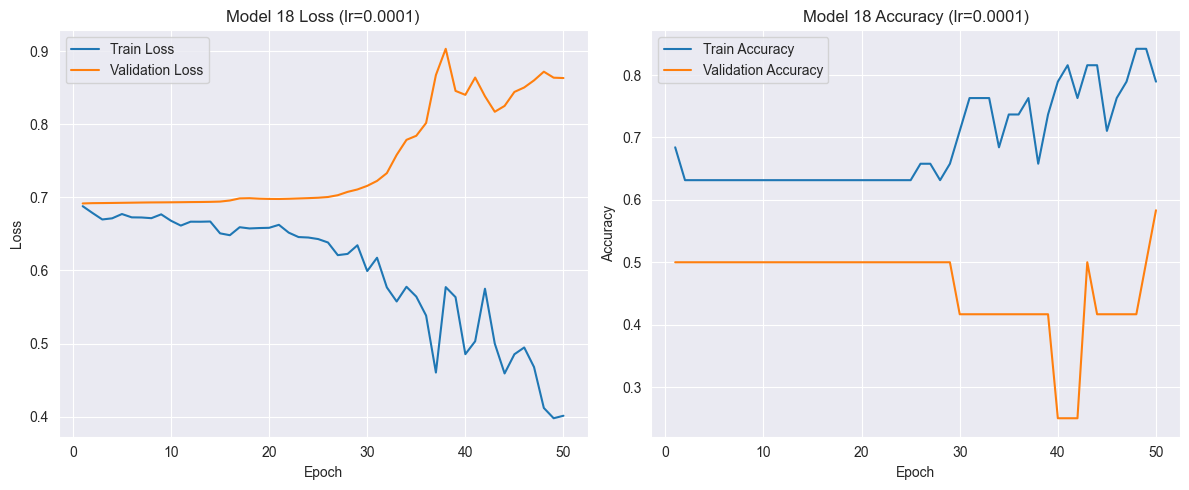

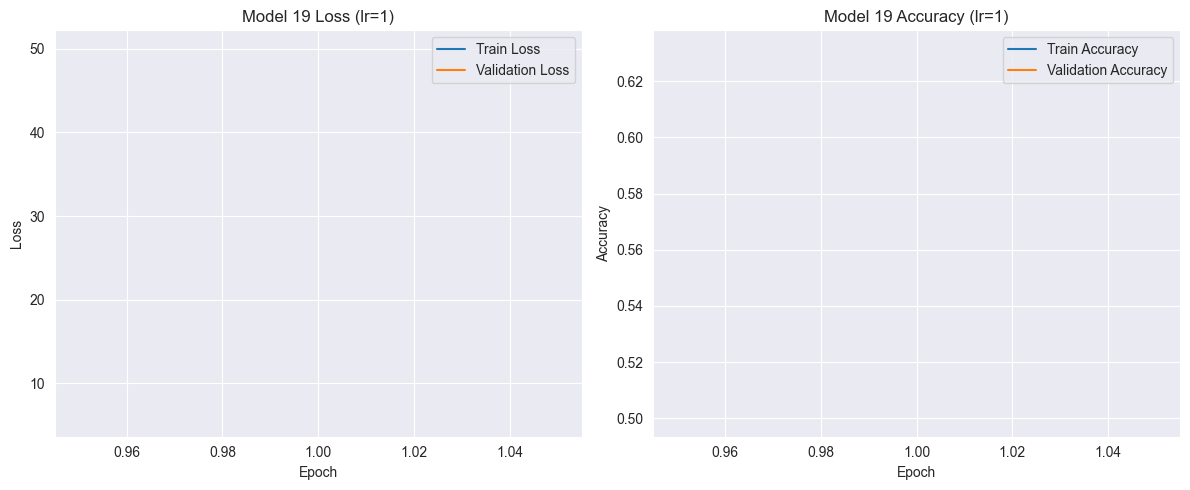

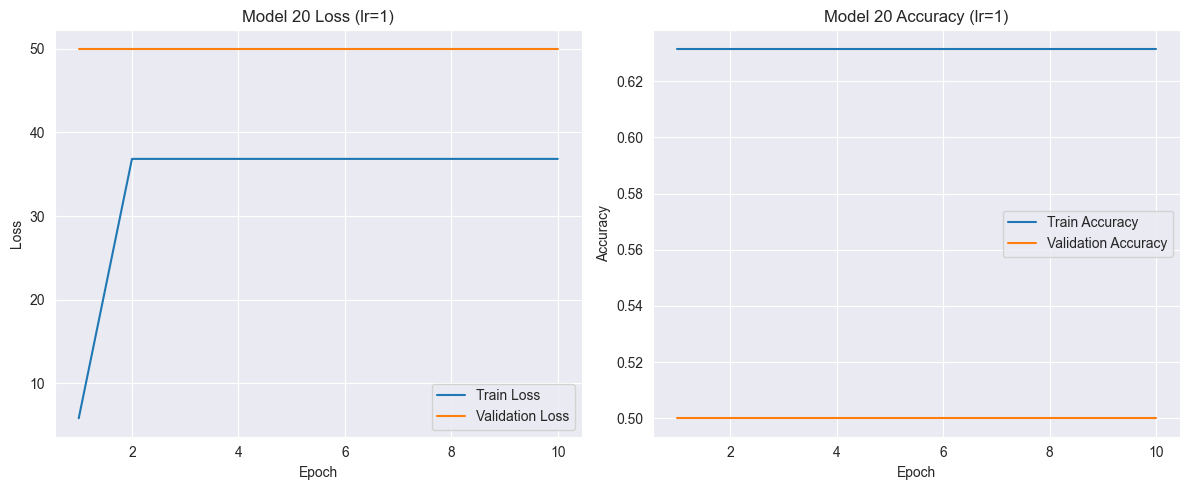

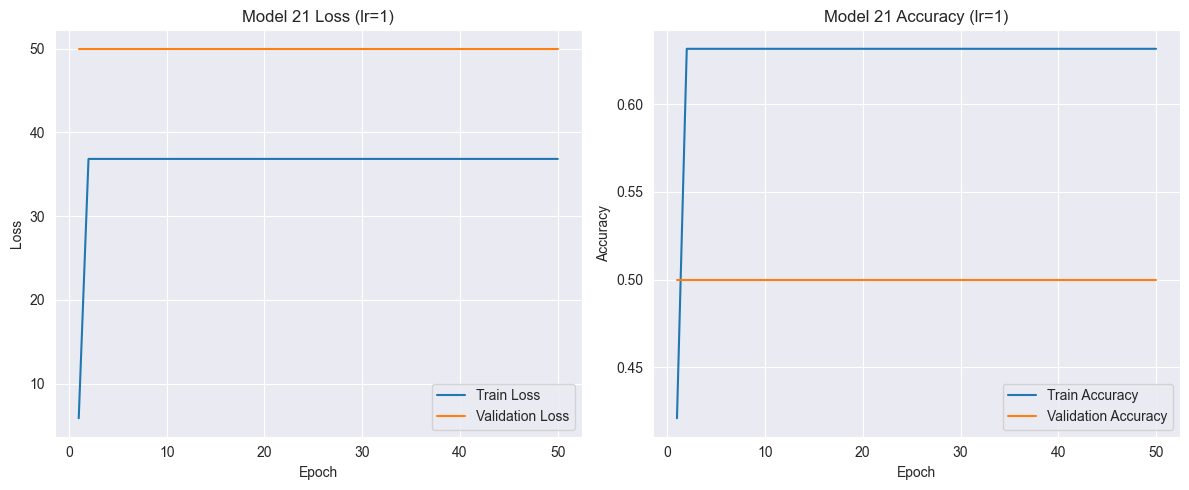

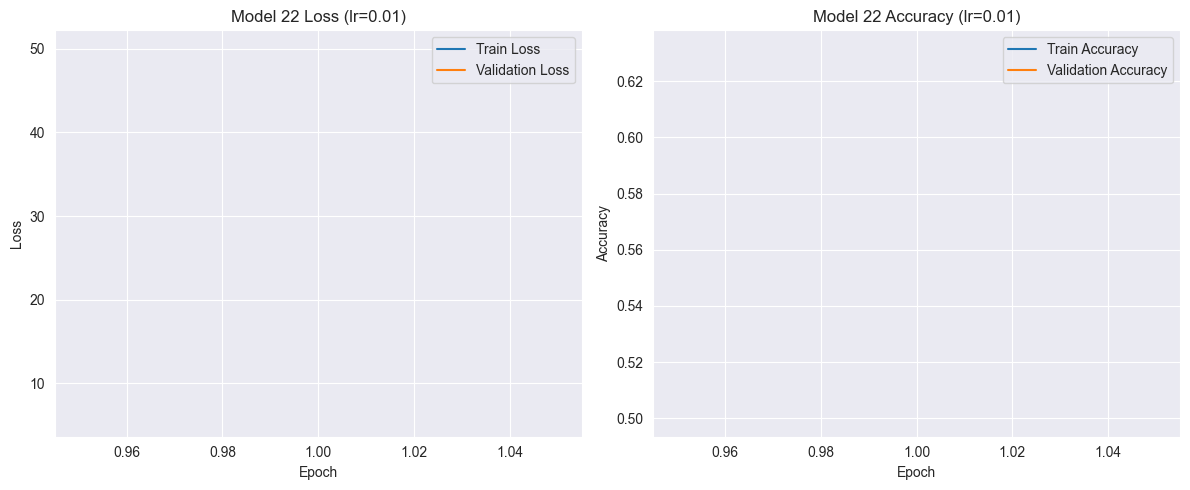

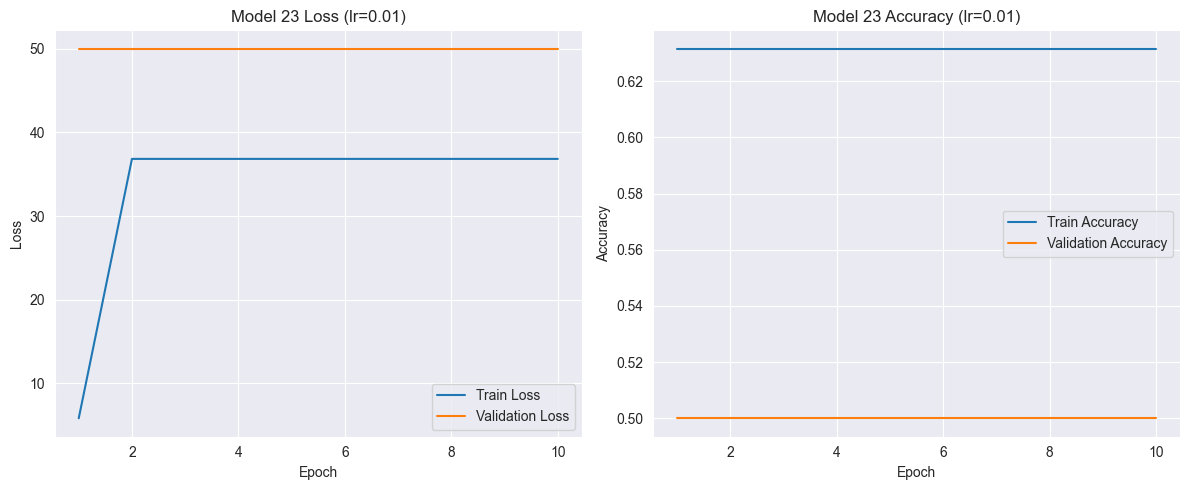

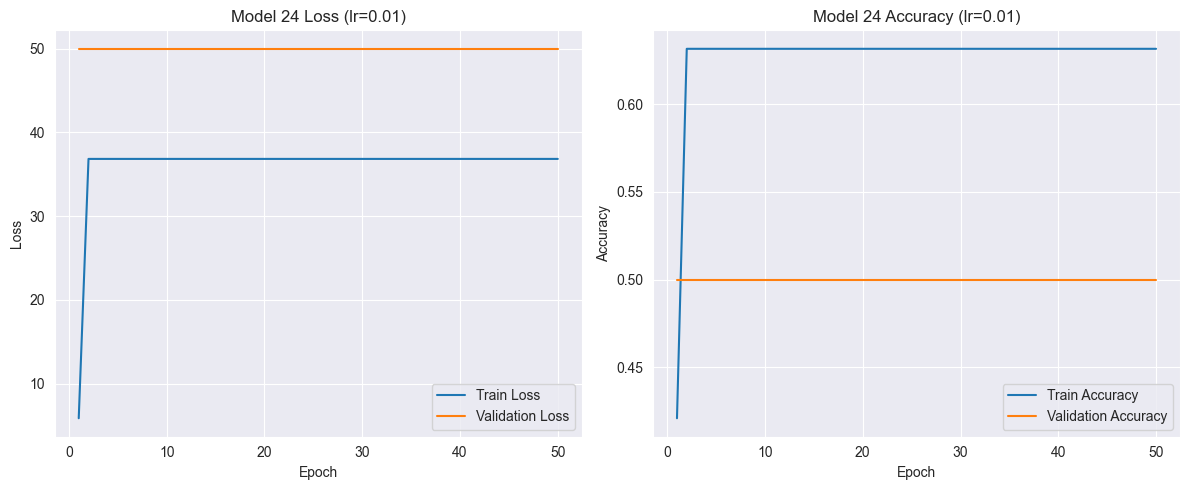

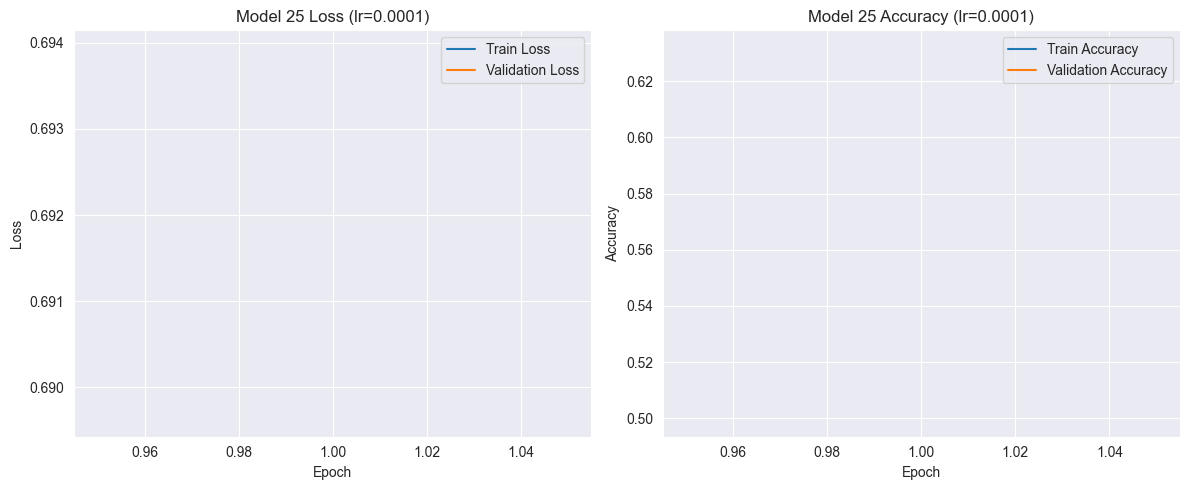

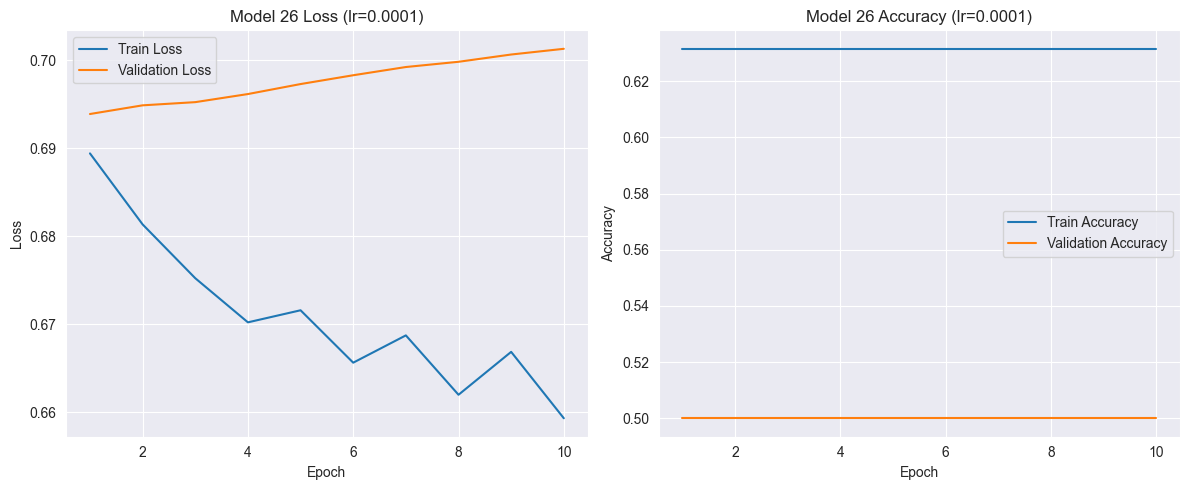

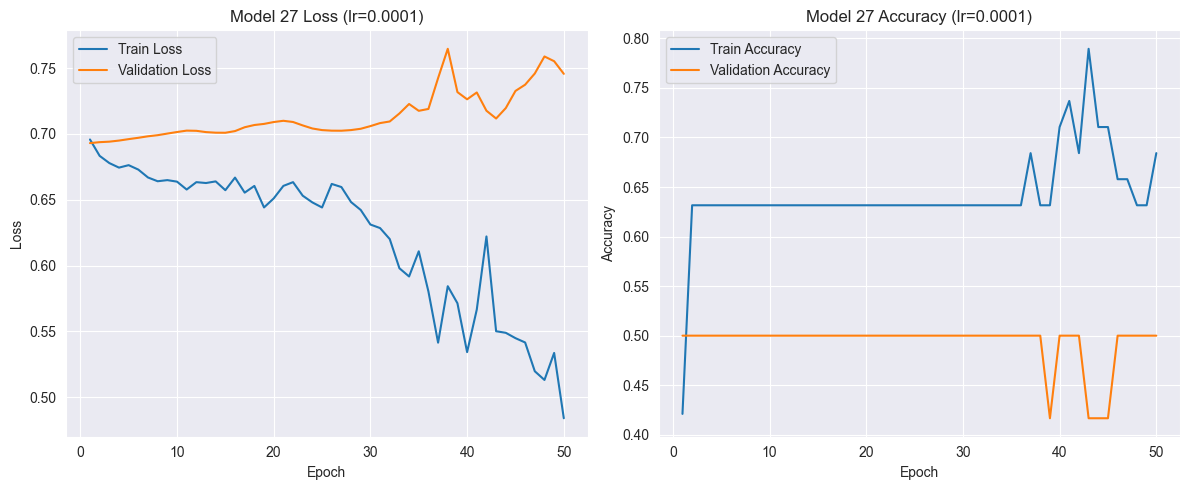

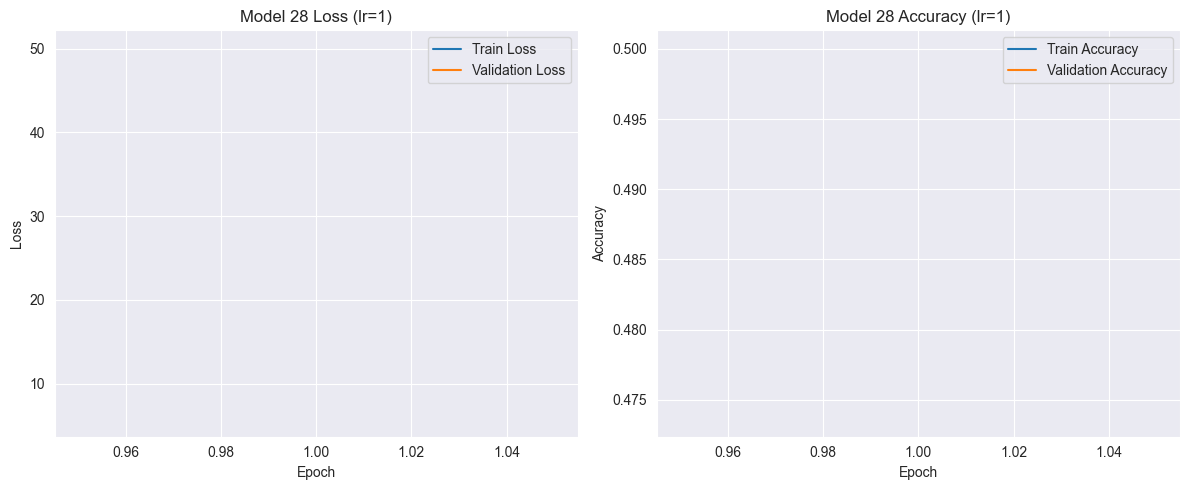

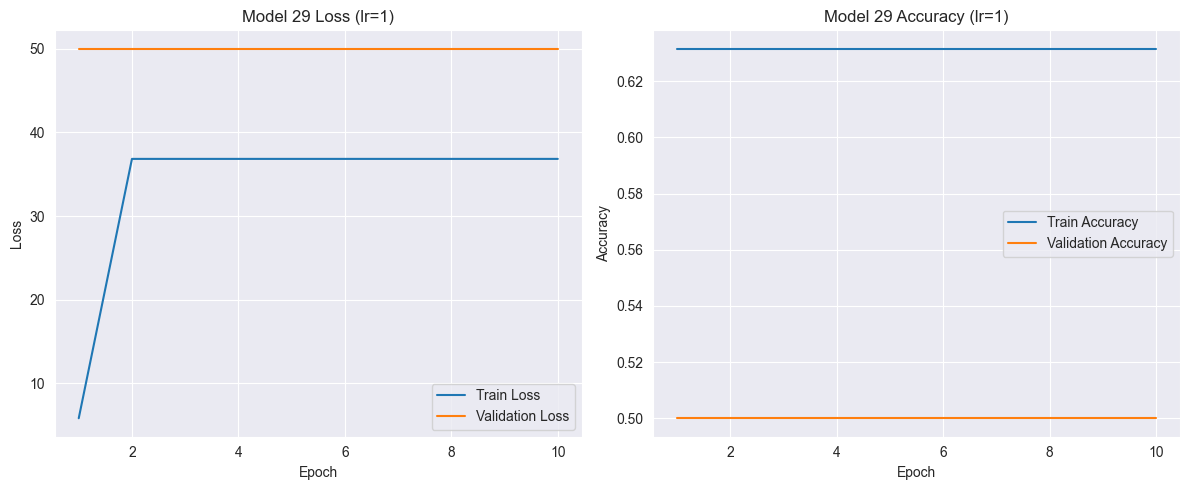

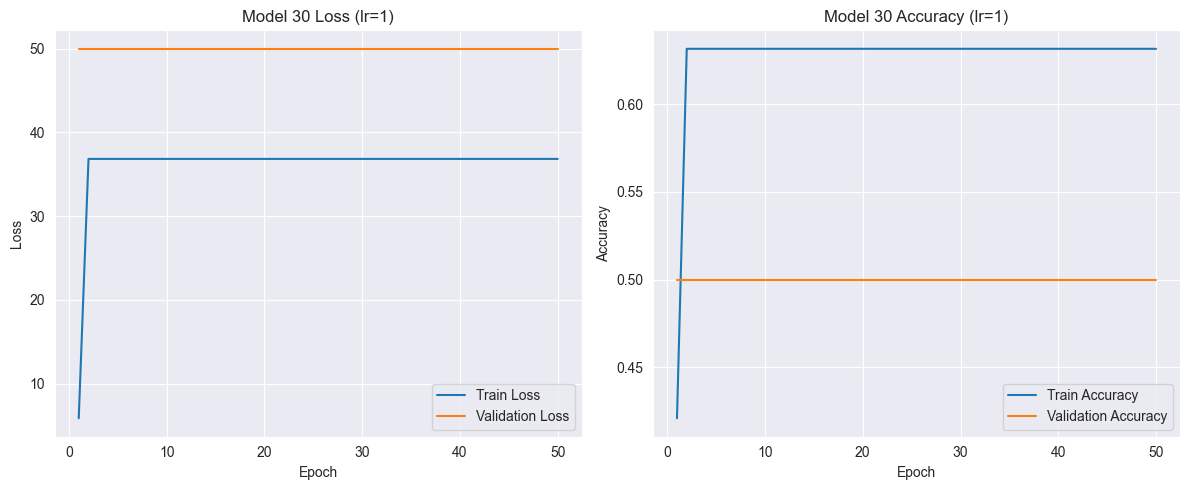

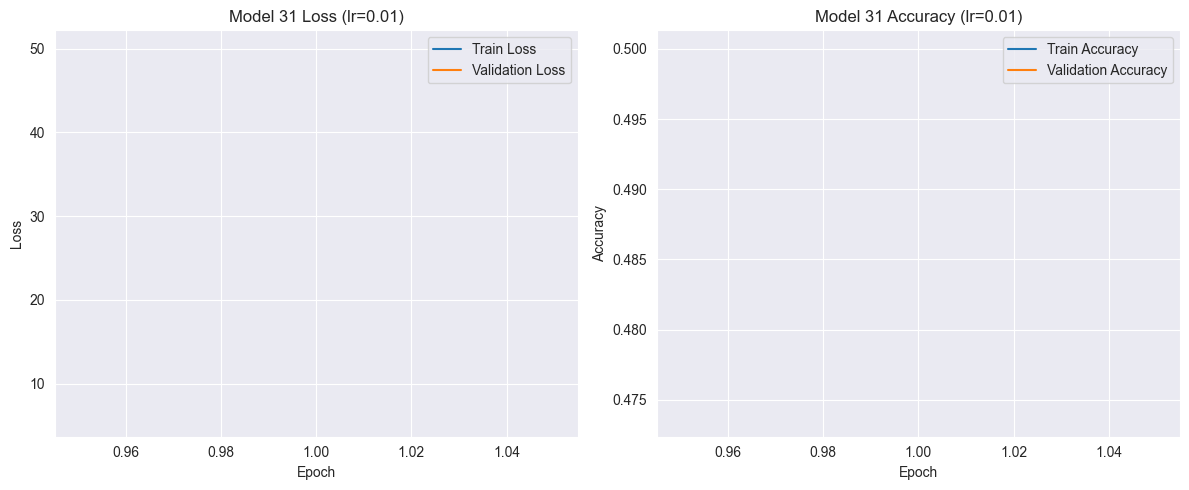

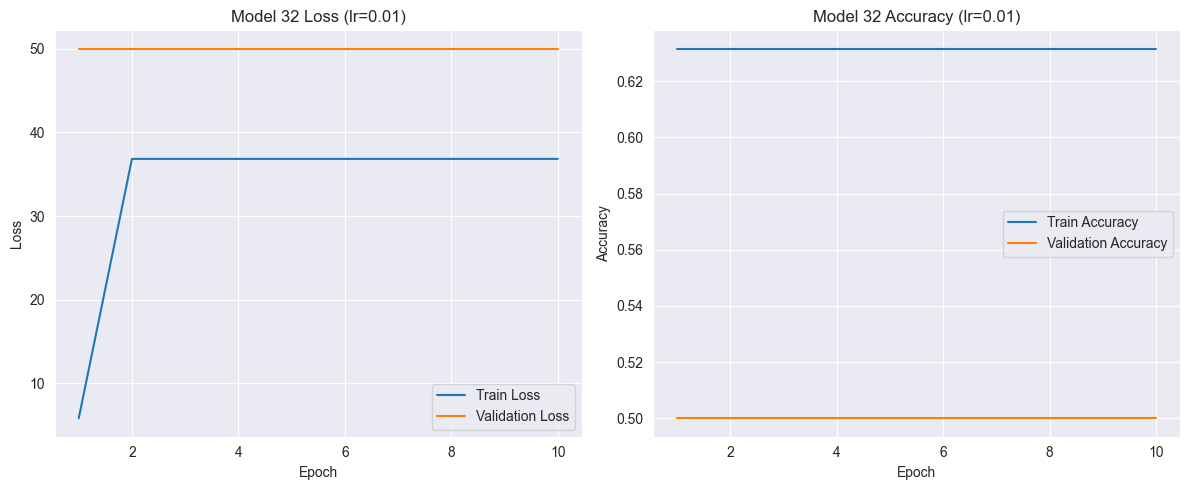

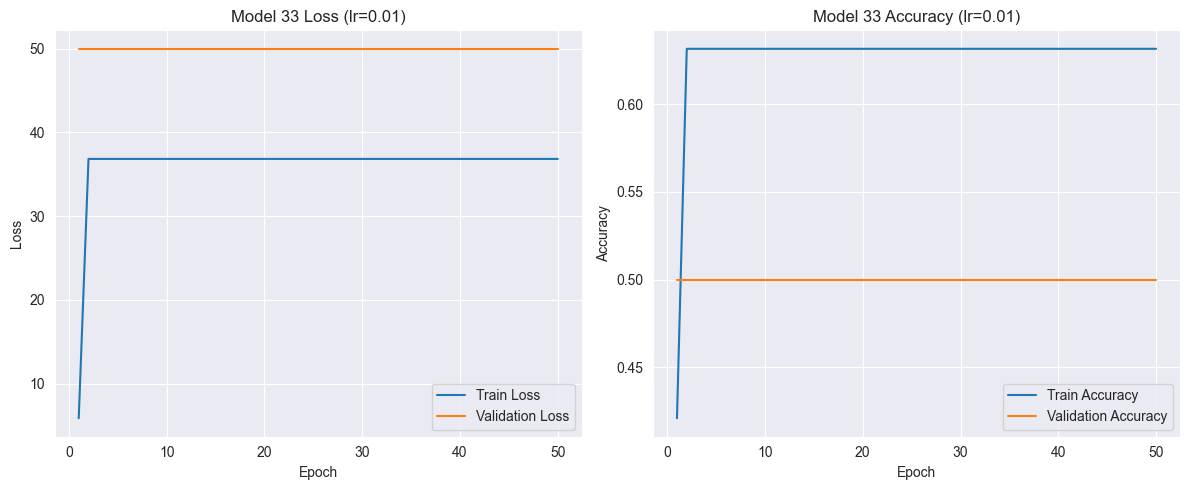

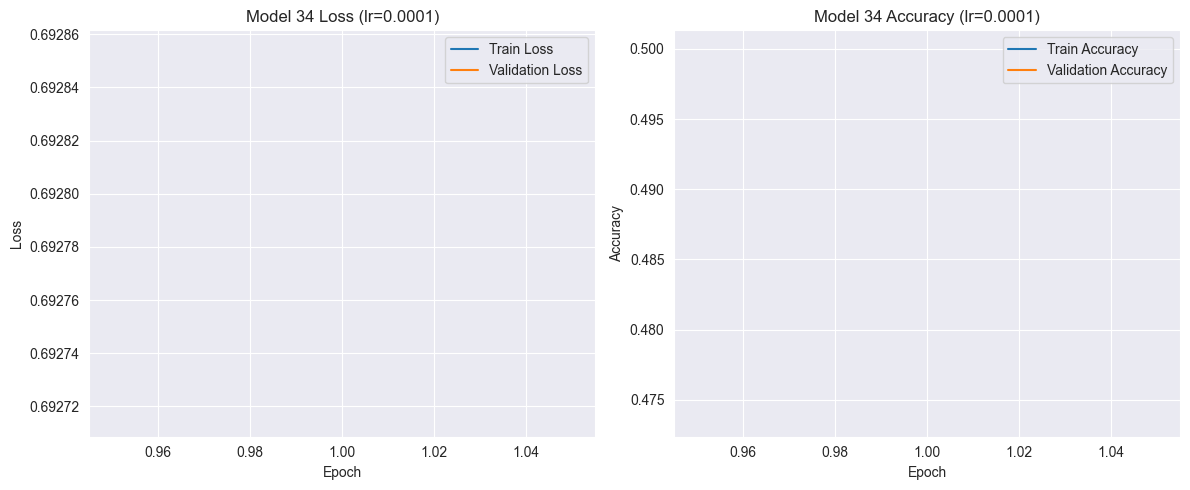

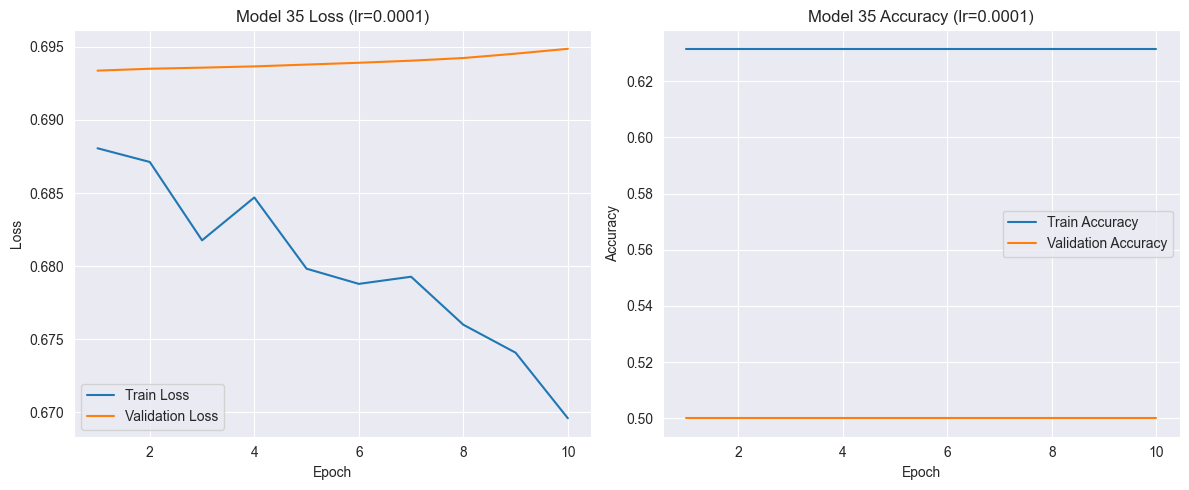

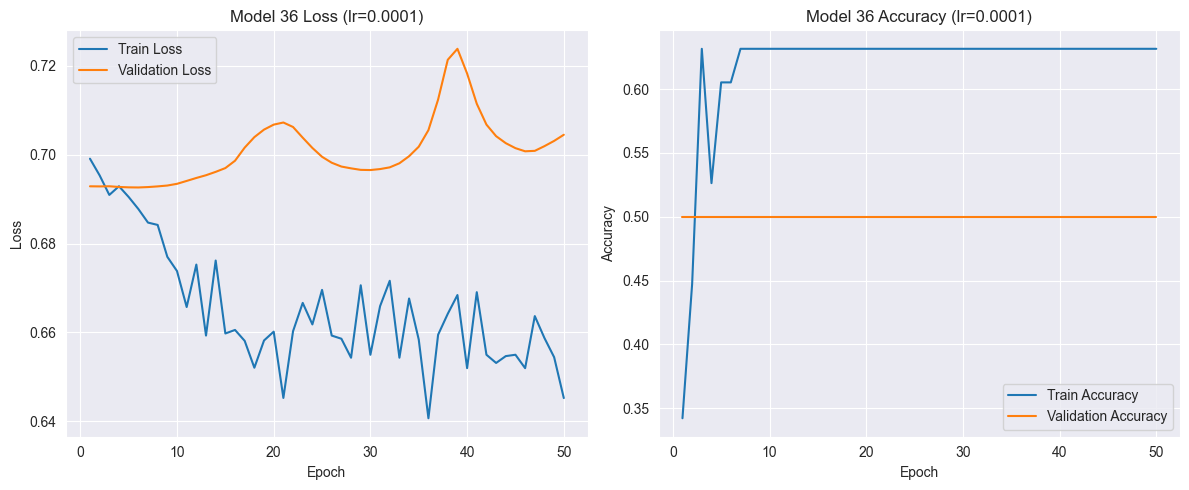

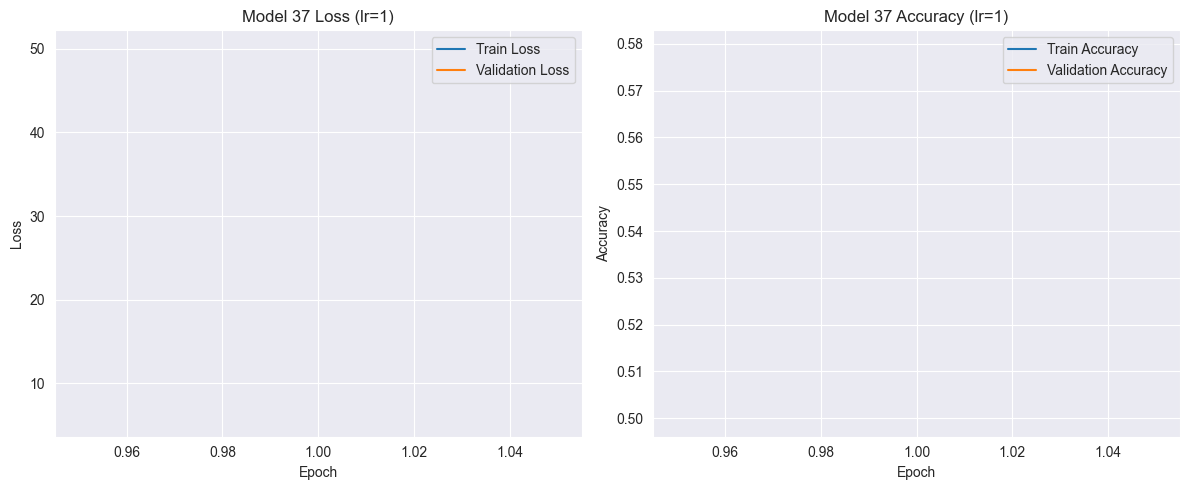

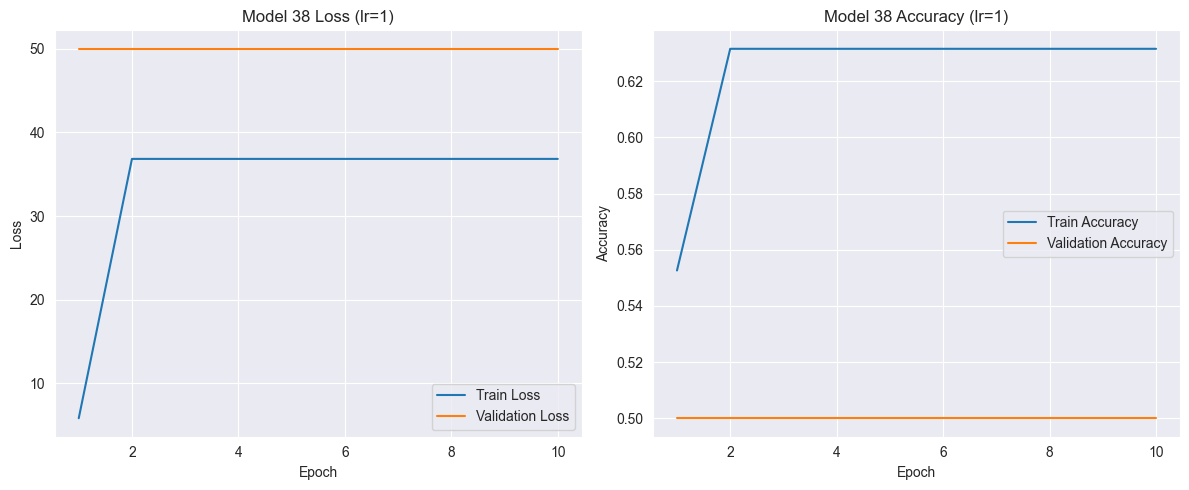

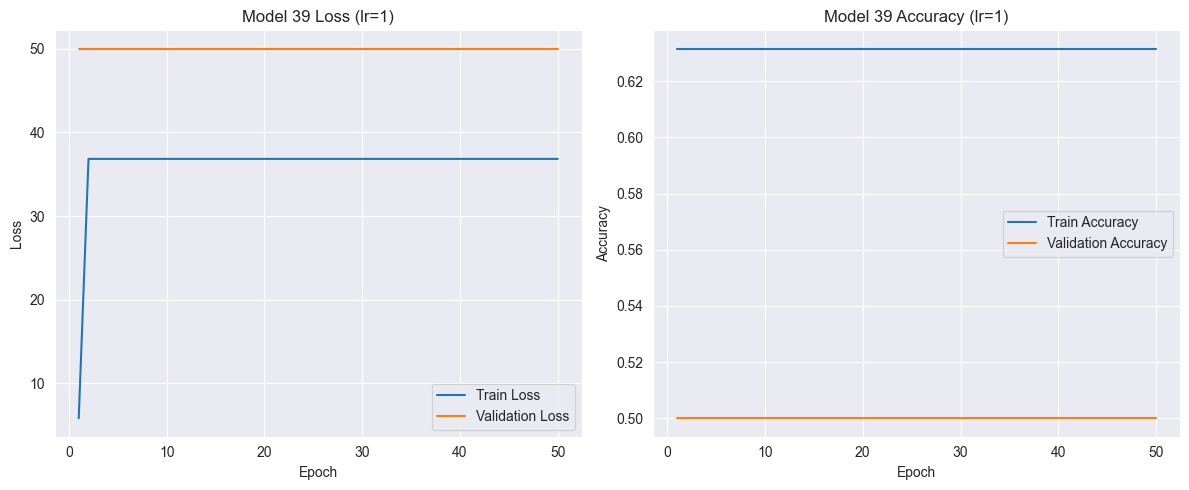

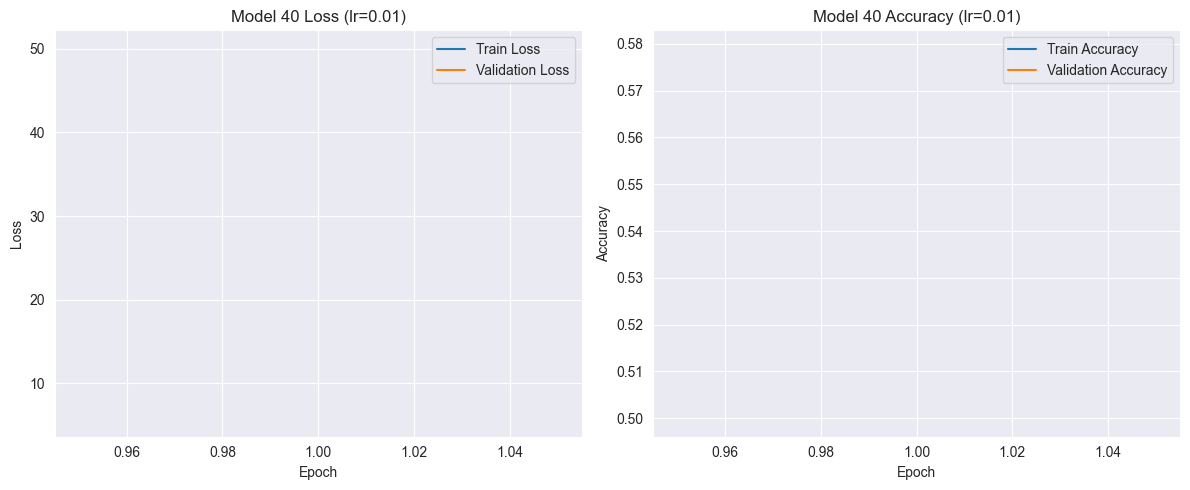

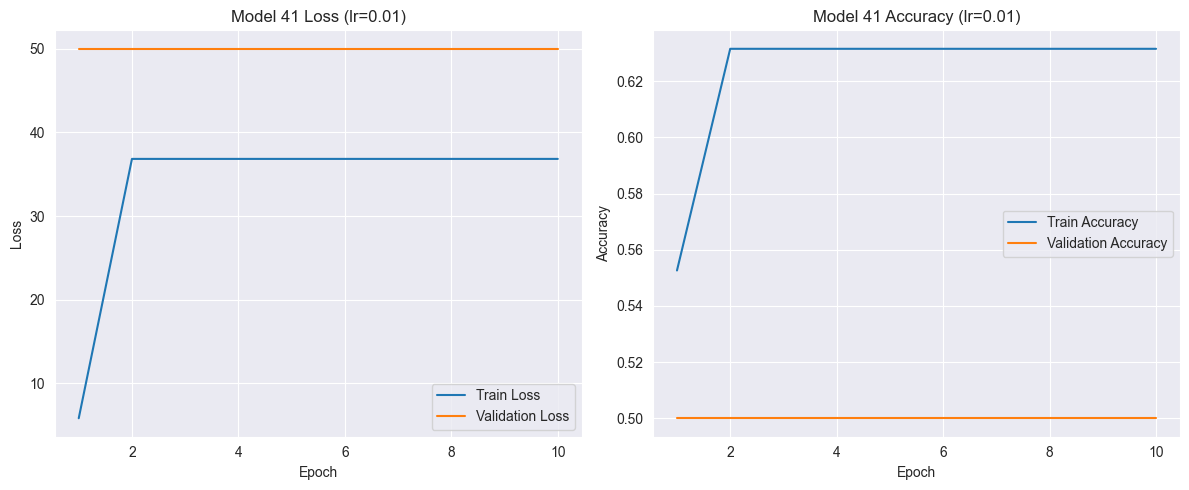

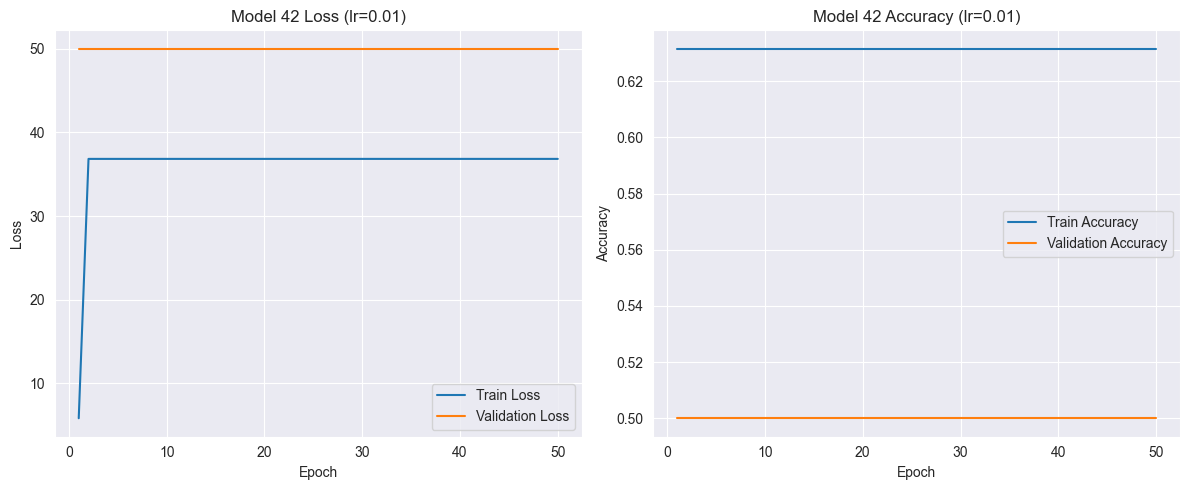

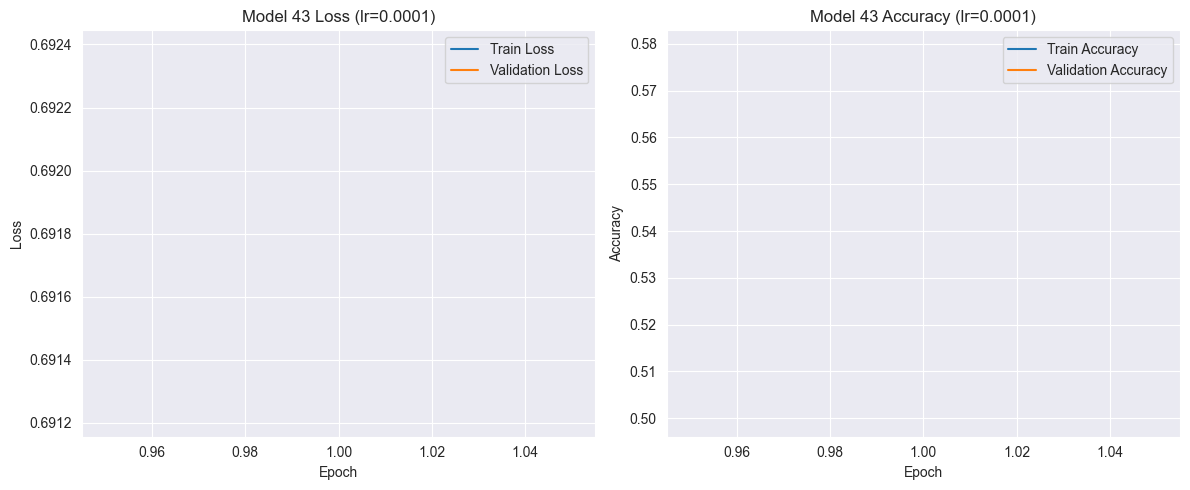

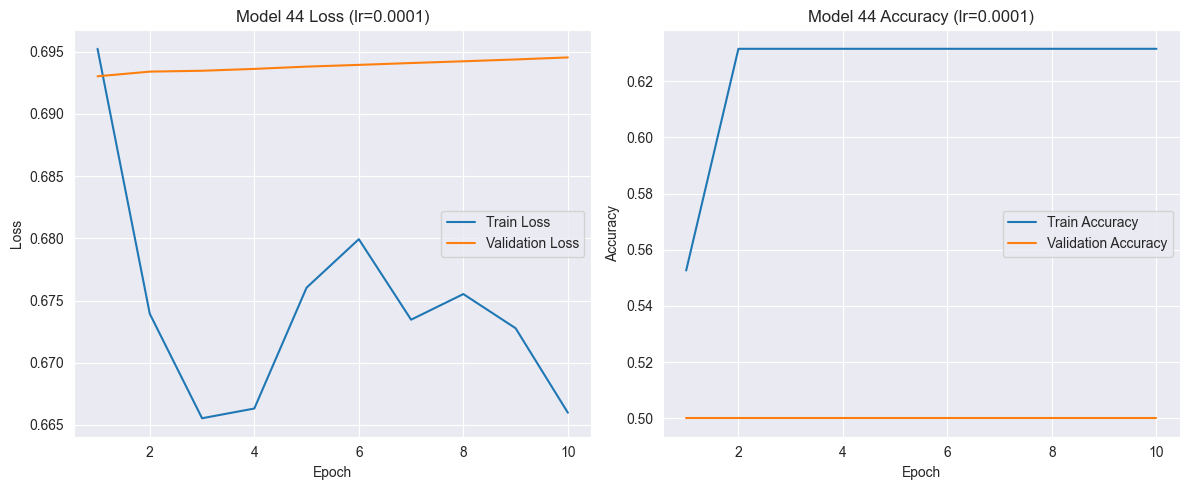

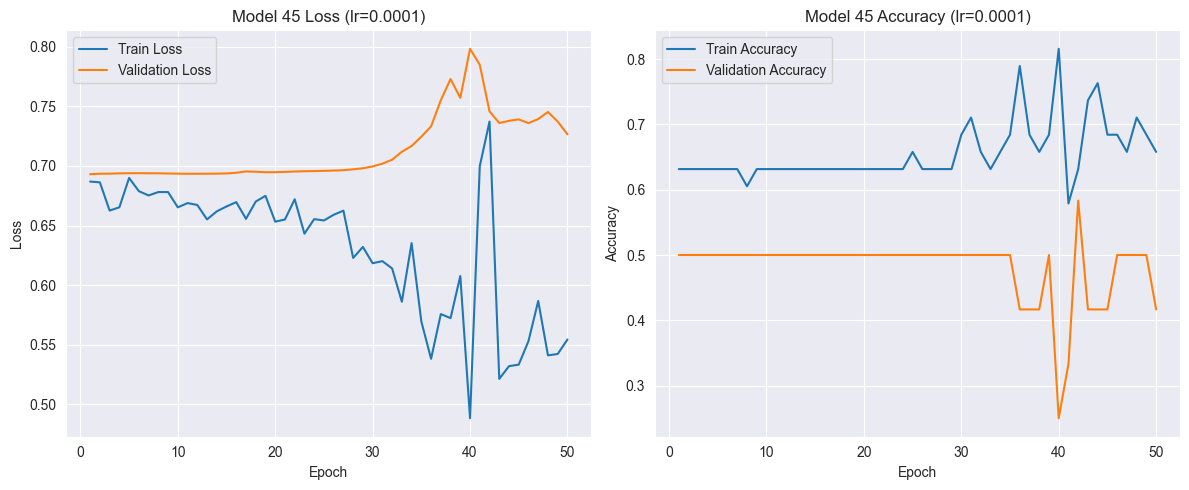

In [33]:
import matplotlib.pyplot as plt

# Loop through all hyperparameter results
for idx, (model, lr, num_epochs, loss_train, loss_valid, acc_train, acc_valid) in enumerate(hyperparameter_history):
    
    # --- Plot Loss ---
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, num_epochs+1), loss_train, label='Train Loss')
    plt.plot(range(1, num_epochs+1), loss_valid, label='Validation Loss')
    plt.title(f'Model {idx+1} Loss (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # --- Plot Accuracy ---
    plt.subplot(1,2,2)
    plt.plot(range(1, num_epochs+1), acc_train, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), acc_valid, label='Validation Accuracy')
    plt.title(f'Model {idx+1} Accuracy (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


The best model from this tuning was actually worse than our baseline model (Likely due to local extrema), so we will use our base model as our picked model.

## part e

Evaluating best model

In [13]:
torch.manual_seed(1)

# Uses gpu is possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creates the CNN backbone as a Sequential model
model = nn.Sequential()

# --- Conv Block 1 ---
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   # 500 -> 250
model.add_module('dropout1', nn.Dropout(p=0.25))

# --- Conv Block 2 ---
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))   # 250 -> 125
model.add_module('dropout2', nn.Dropout(p=0.25))

# --- Conv Block 3 ---
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))   # 125 -> 62

# --- Conv Block 4 ---
model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

# --- Adaptive Pooling to reduce flattened size ---
# This ensures output size is always [batch, 256, 8, 8] regardless of input
model.add_module('adaptive_pool', nn.AdaptiveAvgPool2d((8, 8)))

# --- Flatten before fully connected ---
model.add_module('flatten', nn.Flatten())  # 256*8*8 = 16384 features

# ------------------------
# Box 13: Fully connected + output
# ------------------------

# Fully connected layer
model.add_module('fc', nn.Linear(256*8*8, 512))
model.add_module('relu_fc', nn.ReLU())
model.add_module('dropout_fc', nn.Dropout(p=0.5))

# Output layer for binary classification
model.add_module('output', nn.Linear(512, 1))
model.add_module('sigmoid', nn.Sigmoid())

# Assings gpu to model
model = model.to(device)

# Creates loss function
loss_fn = nn.BCELoss()

# Initalizes optimizer funciton
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Trains and gives history to hist
loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train(model, 100, train_loader, val_loader)

Epoch 1 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 2 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 3 accuracy: 0.5263 val_accuracy: 0.5000
Epoch 4 accuracy: 0.3947 val_accuracy: 0.5000
Epoch 5 accuracy: 0.4737 val_accuracy: 0.3333
Epoch 6 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 7 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 8 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 9 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 10 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 11 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 12 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 13 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 14 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 15 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 16 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 17 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 18 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 19 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 20 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 21 accuracy: 0.6316 val_accuracy: 0.5000
Epoch 22 accuracy: 0.6

Look at loss and accuracy across epochs

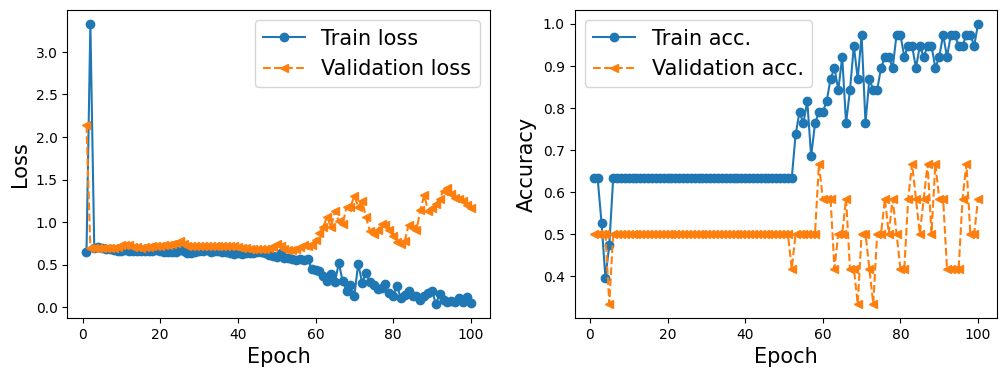

In [14]:
# box 20 describe overall...include if you are happy with 
# Plots results. Overall 50% isn't great
# as it's just a coinflip
x_arr = np.arange(len(accuracy_hist_train)) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, loss_hist_train, '-o', label='Train loss')
ax.plot(x_arr, loss_hist_valid, '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, accuracy_hist_train, '-o', label='Train acc.')
ax.plot(x_arr, accuracy_hist_valid, '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_17.png', dpi=300)
plt.show()

Test accuracy

In [15]:
# box 21
accuracy_test = 0

# Switches to evaluation mode
model.eval()

# Disables gradient computation for getting accuracy
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()

accuracy_test /= len(test_loader.dataset)

print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.7000


In [16]:
# box 23

# imports file system library
import os

# creates directory for models
if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/Group_6_CNN_FullModel.ph'

# Saves model to path
torch.save(model, path)

In [ ]:
# box 24
path = 'models/Group_6_CNN_FullModel.ph'

# Loads the model we just made
#loaded_full_model = torch.load(path, weights_only=False)

# Sets it to evaluation mode
#loaded_full_model.eval()

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(8, 8))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=16384, out_features=512, bias=True)
  (relu_fc): ReLU()
  (dropout_fc): Dropout(p=0.5, inplace=False)
  (output): Linear(in_feat

In [28]:
# # box 25

# from PIL import Image
# image_path = 'FILENAME.jpg'

# # Opens image in color
# img = Image.open(image_path).convert('RGB')

# # makes image a tensor
# img_tensor = transform(img).unsqueeze(0)

# # Disables gradients
# with torch.no_grad():
#     # prediction oject 
#     logit = loaded_full_model(img_tensor)

#     # Gets sigmoid probability of logit
#     probability = torch.sigmoid(logit).item()

# # Prints plot
# plt.figure(figsize=(6, 6))
# plt.imshow(img)
# plt.title(f"Image to Classify: {os.path.basename(image_path)}")
# plt.axis('off')
# plt.show()
# print(f"Classification Result:")
# print(f"pr(Smile): {probability:.4f}")

# # States if image is projected smile or not
# label = "SMILE" if probability >= 0.5 else "NOT SMILING"
# print(f"Predicted Class: {label}")